## Set up

In [0]:
import tensorflow as tf

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow import keras #import keras
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D

Using TensorFlow backend.


In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [0]:
import pathlib

## Retrieve the images

In [6]:
data_dir = tf.keras.utils.get_file(origin='https://drive.google.com/uc?export=download&id=1unk1HNx1HqW91cqi2d6XSgnkIepeYN2w', 
                                   fname='images', extract=True)
data_dir = pathlib.Path(data_dir)

78577664/Unknown - 1s 0us/step

In [0]:
data_dir = pathlib.PosixPath("/root/.keras/datasets/edit_test_img")

In [8]:
print(data_dir)

/root/.keras/datasets/edit_test_img


In [9]:
image_count = len(list(data_dir.glob('*/*.png')))
image_count

3520

In [10]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
CLASS_NAMES

array(['clockalarm', 'motor', 'drop', 'water', 'babycrying'], dtype='<U10')

## Load using tf.data

In [0]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/edit_test_img/motor/0-1012.png'
b'/root/.keras/datasets/edit_test_img/water/1-364.png'
b'/root/.keras/datasets/edit_test_img/motor/0-389.png'
b'/root/.keras/datasets/edit_test_img/water/1-19.png'
b'/root/.keras/datasets/edit_test_img/water/1-591.png'


In [0]:
train_num = int(image_count * 0.7)
test_num = int(image_count * 0.2)
val_num = int(image_count * 0.1)

In [0]:
learning_rate = 0.001
training_epochs = 100
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(val_num/BATCH_SIZE)
TEST_STEPS = np.ceil(test_num/BATCH_SIZE)

파일 경로를 `(img, label)`쌍으로 변환하는 tensorflow 함수

In [0]:
def get_label(file_path):
  #path를 path 구성 요소 목록으로 변환
  parts = tf.strings.split(file_path, os.path.sep)
  # 마지막 두 번째가 클래스 디렉터리임
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # 압축된 문자열을 3D uint8 텐서로 변환
  img = tf.image.decode_png(img, channels=3)
  # convert_image_dtype로 [0,1] 범위의 float로 변환
  img = tf.image.convert_image_dtype(img, tf.float32)
  # 이미지 크기를 원하는 크기로 조정
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # 파일에서 raw data를 문자열로 로드
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`image, label` 쌍 데이터셋 만들기 위해 `Dataset.map`사용하기

In [0]:
# 이미지가 병렬로 로드/처리되도록 'num_parallel_calls'를 설정한다.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [19]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]


In [0]:
train_ = labeled_ds.take(train_num)
test_ = labeled_ds.take(test_num)
val_ = labeled_ds.take(val_num)

In [21]:
for image, label in train_.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False  True False]
Image shape:  (224, 224, 3)
Label:  [False  True False False False]
Image shape:  (224, 224, 3)
Label:  [False False False  True False]
Image shape:  (224, 224, 3)
Label:  [False False  True False False]
Image shape:  (224, 224, 3)
Label:  [False  True False False False]


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # 이것은 작은 데이터 집합으로, 한 번만 로드하여 메모리에 보관한다.
  # 데이터셋의 사전 처리 작업을 캐싱하기 위해 '.cache(filename)' 사용
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE)

  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_)
test_ds = prepare_for_training(test_)
val_ds = prepare_for_training(val_)

In [24]:
for image_batch, labels_batch in train_ds:
  print('batch data size:', image_batch.shape)
  print('batch label size:', labels_batch.shape)
  break

batch data size: (64, 224, 224, 3)
batch label size: (64, 5)


## 모델 구성

In [0]:
class AcousticSoundModel(tf.keras.Model):
    def __init__(self):
        super(AcousticSoundModel, self).__init__()
        self.conv1 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop1 = Dropout(rate=0.2)
        self.pool1 = MaxPool2D(padding='SAME') ###### pooling 2x2. stride는 표기 x, 확인 ######
        
        self.conv2 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop2 = Dropout(rate=0.2) #20% dropout
        self.pool2 = MaxPool2D(padding='SAME')
        
        self.conv3 = Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu)
        self.drop3 = Dropout(rate=0.2) #20% dropout
        self.pool3 = MaxPool2D(padding='SAME')
        
        self.pool3_flat = keras.layers.Flatten()
        self.dense4 = Dense(units=128, activation=tf.nn.relu)
        self.dense5 = Dense(units=5, activation=tf.nn.sigmoid) ### 일단 5. class 개수 추가되는 대로 변경
        
    def call(self, inputs, training=False):
        net = self.conv1(inputs)
        net = self.drop1(net)
        net = self.pool1(net)
        
        net = self.conv2(net)
        net = self.drop2(net)
        net = self.pool2(net)
        
        net = self.conv3(net)
        net = self.drop3(net)
        net = self.pool3(net)
        
        net = self.pool3_flat(net)
        net = self.dense4(net)
        net = self.dense5(net)
        return net

In [0]:
model = AcousticSoundModel()

## Training

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['acc'])

In [0]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [0]:
save = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [0]:
callback = [es, save]

In [31]:
hist = model.fit(
      train_ds,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=training_epochs,
      batch_size = BATCH_SIZE,
      validation_data=val_ds,
      validation_steps=VALIDATION_STEPS,
      callbacks=callback)

Epoch 1/100
55/55 [==============================] - 42s 767ms/step - loss: 1.1280 - acc: 0.3449 - val_loss: 1.0688 - val_acc: 0.3984
Epoch 2/100
55/55 [==============================] - 21s 375ms/step - loss: 0.7686 - acc: 0.3568 - val_loss: 0.6348 - val_acc: 0.4219
Epoch 3/100
55/55 [==============================] - 21s 375ms/step - loss: 0.5977 - acc: 0.4730 - val_loss: 0.4883 - val_acc: 0.9115
Epoch 4/100
55/55 [==============================] - 21s 375ms/step - loss: 0.1234 - acc: 0.9548 - val_loss: 0.1205 - val_acc: 0.9948
Epoch 5/100
55/55 [==============================] - 21s 376ms/step - loss: 0.0553 - acc: 0.9804 - val_loss: 0.0814 - val_acc: 0.9896
Epoch 6/100
55/55 [==============================] - 21s 374ms/step - loss: 0.0294 - acc: 0.9901 - val_loss: 0.0433 - val_acc: 0.9974
Epoch 7/100
55/55 [==============================] - 21s 375ms/step - loss: 0.0220 - acc: 0.9937 - val_loss: 0.0395 - val_acc: 0.9948
Epoch 8/100
55/55 [==============================] - 21s 374ms

In [0]:
# 저장된 모델을 언제든지 로드하고 평가할 수 있습니다.
#saved_model = load_model('best_model.h5')

## evaluate / prediction

In [41]:
loss, acc = model.evaluate(test_ds, batch_size=BATCH_SIZE, steps=TEST_STEPS)
print('acc: %.2f%%, loss: %f'% (acc*100, loss))

11/11 [==============================] - 1s 102ms/step - loss: 0.0020 - acc: 1.0000
acc: 100.00%, loss: 0.002033


In [42]:
print("-- Predict --")
output = model.predict(test_ds, steps=TEST_STEPS)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(output)

-- Predict --
[[0.000 0.000 0.001 0.468 0.000]
 [0.000 0.999 0.000 0.000 0.000]
 [0.000 0.075 0.000 0.000 0.000]
 ...
 [0.000 1.000 0.000 0.000 0.000]
 [0.000 0.986 0.000 0.000 0.000]
 [0.000 0.999 0.000 0.000 0.000]]


In [0]:
model.save_weights('saveweights', save_format='tf')

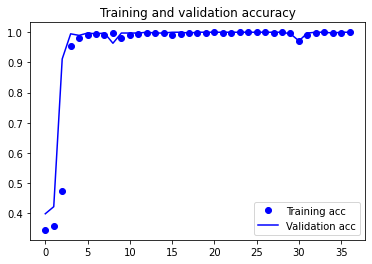

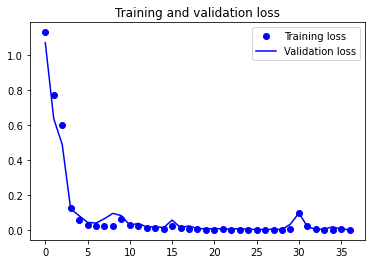

In [44]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# Explore your VM
#!ls -la /
# Find disk space and RAM space
#!df -h
#!free -m

#What OS is your VM using:
#!cat /etc/os-release

In [0]:
#!ls  /root/.keras/datasets/

In [0]:
#!ls  /root/.keras/datasets/images.tar.gz/